In [11]:
from catboost import CatBoostRegressor

from lightgbm import LGBMRegressor

import matplotlib.pyplot as plt

import numpy as np

import pandas as pd

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor

from statsmodels.tsa.seasonal import seasonal_decompose

import warnings

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

План работ:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [12]:
df = pd.read_csv('/datasets/taxi.csv')
df.info()
display(df.describe(include='all'))
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


,datetime,num_orders
count,26496,26496.000000
unique,26496,NaN
top,2018-03-03 20:40:00,NaN
freq,1,NaN
mean,NaN,14.070463
std,NaN,9.211330
min,NaN,0.000000
25%,NaN,8.000000
50%,NaN,13.000000
75%,NaN,19.000000


,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32


Пропусков в df нет, все значения 'datetime' уникальны, выбросов в 'num_orders' нет.

In [13]:
df['datetime'] = pd.to_datetime(df['datetime'])
df[['datetime']].describe(datetime_is_numeric=True)

,datetime
count,26496
mean,2018-05-31 23:55:00
min,2018-03-01 00:00:00
25%,2018-04-15 23:57:30
50%,2018-05-31 23:55:00
75%,2018-07-16 23:52:30
max,2018-08-31 23:50:00


Временной интервал в 'datetime' - пол года ровно.

Значения 'datetime', расположенные в хронологическом порядке, используем в качестве индекса. Выполним ресемплирование по 1 часу.

In [14]:
df = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
print(df.index.is_monotonic)
df = df.resample('1H').sum()

True


Данные готовы для анализа и обучения.

## Анализ

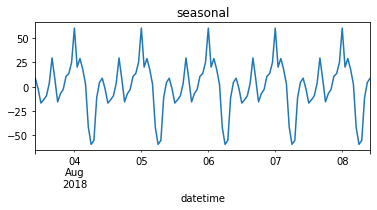

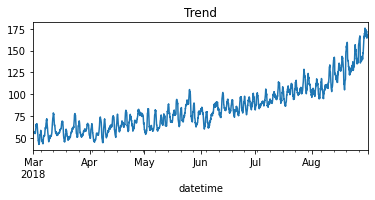

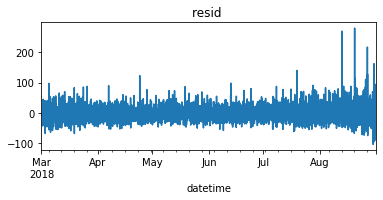

In [15]:
decomposed = seasonal_decompose(df)

plt.figure(figsize=(6, 8))
plt.subplot(311)
decomposed.seasonal['2018-08-03 10' : '2018-08-08 10'].plot(ax=plt.gca())
plt.title('seasonal')

plt.figure(figsize=(6, 8))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')

plt.figure(figsize=(6, 8))
plt.subplot(311)
decomposed.resid.plot(ax=plt.gca())
plt.title('resid ')
plt.show()

Результаты функции seasonal_decompose показывают: тренд - постепенное увеличение заказов с в течение всего периода работы, сезонность - в течение суток, ночью заказов меньше; так же присутствуют пики объёмов заказов: утром, больше - к обеду и самый большой - ближе к полуночи. Остатки - необъеснимы.

График временного ряда:


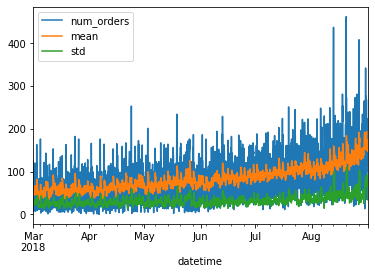

График разности временного ряда:


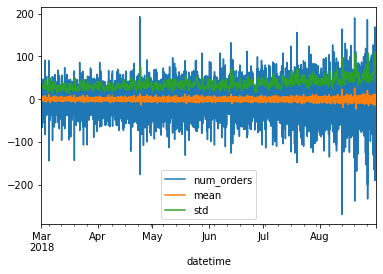

In [16]:
df_ = df.copy()

print('График временного ряда:')
df_['mean'] = df_['num_orders'].rolling(15).mean()
df_['std'] = df_['num_orders'].rolling(15).std()
df_.plot()
plt.show()

print('График разности временного ряда:')
df_shift = df_ - df_.shift()
df_shift['mean'] = df_shift['num_orders'].rolling(15).mean()
df_shift['std'] = df_shift['num_orders'].rolling(15).std()
df_shift.plot()
plt.show()

График разности временного ряда более стационарный, такие данные можно использовать для прогноза.

## Обучение

In [17]:
# функция для создания признаков:

def make_features(data, max_lag, rolling_mean_size):
    data['dayofweek'] = data.index.dayofweek
    data['day'] = data.index.day
    data['hour'] = data.index.hour
    data['minute'] = data.index.minute
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data.iloc[:, 0].shift(lag)

    data['rolling_mean'] = data.iloc[:, 0].shift().rolling(rolling_mean_size).mean()

In [18]:
# Разделим df на тренеровочную (90%) и тестовую (10%) выборки:

df_train, df_test = train_test_split(df, shuffle=False, test_size=0.1)

print('df_train.shape:', df_train.shape)
print('df_test.shape:', df_test.shape)

df_train.shape: (3974, 1)
df_test.shape: (442, 1)


### LinearRegression

In [19]:
warnings.simplefilter("ignore")

RMSE_best = 10000

for i in range(1, 10):
    for j in range(2, 20):
        df_ = df_train.copy()
        model = LinearRegression()
        make_features(df_, i, j)
        train, validation = train_test_split(df_, shuffle=False, test_size=0.1)
        train = train.dropna()
        train_ft = train.drop('num_orders', axis = 1)
        train_tg = train['num_orders']
        test_ft = validation.drop('num_orders', axis = 1)
        test_tg = validation['num_orders']
        model.fit(train_ft, train_tg)
        predict = model.predict(test_ft)
        RMSE = mean_squared_error(test_tg, predict, squared=False)
        if RMSE < RMSE_best:
            RMSE_best = RMSE
            i_best = i
            j_best = j
            LinearRegression_best = model
        
        
            
print('Параметры функции make_features: max_lag =', i_best, ', rolling_mean_size =', j_best)
print('RMSE LinearRegression на валидационной выборке:', RMSE_best)

Параметры функции make_features: max_lag = 9 , rolling_mean_size = 12
RMSE LinearRegression на валидационной выборке: 41.82976154930659


### DecisionTreeRegressor

In [20]:
RMSE_best = 10000

for i in range(1, 10):
    for j in range(2, 20):
        df_ = df_train.copy()
        for depth in range(1, 13):
            model = DecisionTreeRegressor(random_state=12345, max_depth=depth)
            make_features(df_, i, j)
            train, validation = train_test_split(df_, shuffle=False, test_size=0.1)
            train = train.dropna()
            train_ft = train.drop('num_orders', axis = 1)
            train_tg = train['num_orders']
            test_ft = validation.drop('num_orders', axis = 1)
            test_tg = validation['num_orders']
            model.fit(train_ft, train_tg)
            predict = model.predict(test_ft)
            RMSE = mean_squared_error(test_tg, predict, squared=False)
            if RMSE < RMSE_best:
                RMSE_best = RMSE
                i_best = i
                j_best = j
                depth_best = depth
                DecisionTreeRegressor_best = model
        
        
            
print('Параметры функции make_features: max_lag =', i_best, ', rolling_mean_size =', j_best)
print('Параметры DecisionTreeRegressor: max_depth =', depth_best)
print('RMSE на валидационной выборке:', RMSE_best)

Параметры функции make_features: max_lag = 5 , rolling_mean_size = 13
Параметры DecisionTreeRegressor: max_depth = 8
RMSE на валидационной выборке: 33.05294093465023


### RandomForestRegressor

In [21]:
RMSE_best = 10000

for i in [1, 3, 9, 12]:
    for j in [3, 7, 12]:
        df_ = df_train.copy()
        for depth in [1, 5, 20]:
            for est in [10, 25, 150]:
                model = RandomForestRegressor(random_state=12345, 
                                              max_depth=depth,
                                              n_estimators=est)
                make_features(df_, i, j)
                train, validation = train_test_split(df_, shuffle=False, test_size=0.1)
                train = train.dropna()
                train_ft = train.drop('num_orders', axis = 1)
                train_tg = train['num_orders']
                test_ft = validation.drop('num_orders', axis = 1)
                test_tg = validation['num_orders']
                model.fit(train_ft, train_tg)
                predict = model.predict(test_ft)
                RMSE = mean_squared_error(test_tg, predict, squared=False)
                if RMSE < RMSE_best:
                    RMSE_best = RMSE
                    i_best = i
                    j_best = j
                    depth_best = depth
                    est_best = est
                    RandomForestRegressor_best = model
        
        
            
print('Параметры функции make_features: max_lag =', i_best, ', rolling_mean_size =', j_best)
print('Параметры RandomForestRegressor: max_depth =', depth_best, ', n_estimators =', est_best)
print('RMSE на валидационной выборке:', RMSE_best)

Параметры функции make_features: max_lag = 12 , rolling_mean_size = 12
Параметры RandomForestRegressor: max_depth = 20 , n_estimators = 25
RMSE на валидационной выборке: 31.591398845203635


### CatBoostRegressor

In [22]:
RMSE_best = 10000

for i in [1, 3, 9, 12]:
    for j in [3, 7, 12]:
        df_ = df_train.copy()
        for depth in [1, 4, 8]:
            for iterations in [50, 150]:
                for learning_rate in [.1, .5, 1]:
                    model = CatBoostRegressor(iterations=iterations,
                                              learning_rate=learning_rate, 
                                              depth=depth,
                                              loss_function="RMSE",
                                              verbose=False)
                    make_features(df_, i, j)
                    train, validation = train_test_split(df_, shuffle=False, test_size=0.1)
                    train = train.dropna()
                    train_ft = train.drop('num_orders', axis = 1)
                    train_tg = train['num_orders']
                    test_ft = validation.drop('num_orders', axis = 1)
                    test_tg = validation['num_orders']
                    model.fit(train_ft, train_tg)
                    predict = model.predict(test_ft)
                    RMSE = mean_squared_error(test_tg, predict, squared=False)
                    if RMSE < RMSE_best:
                        RMSE_best = RMSE
                        i_best = i
                        j_best = j
                        depth_best = depth
                        iterations_best = iterations
                        learning_rate_best = learning_rate
                        CatBoostRegressor_best = model
        
        
            
print('Параметры функции make_features: max_lag =', i_best, ', rolling_mean_size =', j_best)
print('Параметры CatBoostRegressor:')
print(f'''depth = {depth_best}
iterations = {iterations_best}
learning_rate = {learning_rate_best}''')
print('RMSE на валидационной выборке:', RMSE_best)

Параметры функции make_features: max_lag = 12 , rolling_mean_size = 12
Параметры CatBoostRegressor:
depth = 8
iterations = 150
learning_rate = 0.1
RMSE на валидационной выборке: 31.346268611786694


### LGBMRegressor

In [23]:
RMSE_best = 10000

for i in [1, 9, 12]:
    for j in [7, 12]:
        df_ = df_train.copy()
        for depth in [6, 10]:
            for iterations in [50, 150]:
                for learning_rate in [.1, .5]:
                    model = LGBMRegressor(n_estimators=iterations,
                                          learning_rate=learning_rate,
                                          max_depth=depth)
                    make_features(df_, i, j)
                    train, validation = train_test_split(df_, shuffle=False, test_size=0.1)
                    train = train.dropna()
                    train_ft = train.drop('num_orders', axis = 1)
                    train_tg = train['num_orders']
                    test_ft = validation.drop('num_orders', axis = 1)
                    test_tg = validation['num_orders']
                    model.fit(train_ft, train_tg)
                    predict = model.predict(test_ft)
                    RMSE = mean_squared_error(test_tg, predict, squared=False)
                    if RMSE < RMSE_best:
                        RMSE_best = RMSE
                        i_best = i
                        j_best = j
                        depth_best = depth
                        iterations_best = iterations
                        learning_rate_best = learning_rate
                        LGBMRegressor_best = model
        
        
            
print('Параметры функции make_features: max_lag =', i_best, ', rolling_mean_size =', j_best)
print('Параметры LGBMRegressor:')
print(f'''max_depth = {depth_best}
n_estimators = {iterations_best}
learning_rate = {learning_rate_best}''')
print('RMSE на валидационной выборке:', RMSE_best)

Параметры функции make_features: max_lag = 12 , rolling_mean_size = 12
Параметры LGBMRegressor:
max_depth = 6
n_estimators = 150
learning_rate = 0.1
RMSE на валидационной выборке: 31.093395953434555


## Тестирование

### LinearRegression

In [24]:
df_ = df_test.copy()
make_features(df_, 9, 12)
df_ = df_.dropna()

df_t = df_train.copy()
make_features(df_t, 9, 12)
df_t = df_t.dropna()

LinearRegression_best = LinearRegression().fit(df_t.drop('num_orders', axis = 1), df_t['num_orders'])

print('RMSE на тестовой выборке лучшей LinearRegression модели:')
predict = LinearRegression_best.predict(df_.drop('num_orders', axis = 1))
mean_squared_error(df_['num_orders'],
                   predict,
                   squared=False)

RMSE на тестовой выборке лучшей LinearRegression модели:


52.893453390054496

In [44]:
# Функция для графика за последние 3 дня.

def plot_show():
    print('График за последние 3 дня.')
    df_['predict'] = predict
    df_['2018-08-29':'2018-08-31']['num_orders'].plot(figsize=(12, 5),
                                                      linewidth=3,
                                                      alpha=.8,
                                                      label='target',
                                                      ylabel='Количество заказов',
                                                      legend=True)

    df_['2018-08-29':'2018-08-31']['predict'].plot(figsize=(12, 5),
                                                   linewidth=3,
                                                   alpha=.6,
                                                   label='predict',
                                                   xlabel='Дата/Время',
                                                   grid=True,
                                                   legend=True)

    plt.show()

График за последние 3 дня.


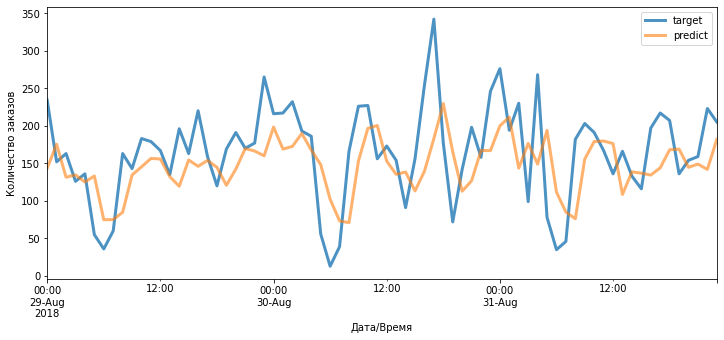

In [26]:
plot_show()

Значение RMSE на тестовой выборке лучшей LinearRegression модели > 48, требуемый уровень не достигнут.

### DecisionTreeRegressor

In [27]:
df_ = df_test.copy()
make_features(df_, 5, 13)
df_ = df_.dropna()

df_t = df_train.copy()
make_features(df_t, 5, 13)
df_t = df_t.dropna()

DecisionTreeRegressor_best = DecisionTreeRegressor(random_state=12345,
                                                   max_depth=8).fit(
    df_t.drop('num_orders', axis = 1),
    df_t['num_orders'])

print('RMSE на тестовой выборке лучшей DecisionTreeRegressor модели:')
predict = DecisionTreeRegressor_best.predict(df_.drop('num_orders', axis = 1))
mean_squared_error(df_['num_orders'],
                   predict,
                   squared=False)

RMSE на тестовой выборке лучшей DecisionTreeRegressor модели:


65.32739254582592

График за последние 3 дня.


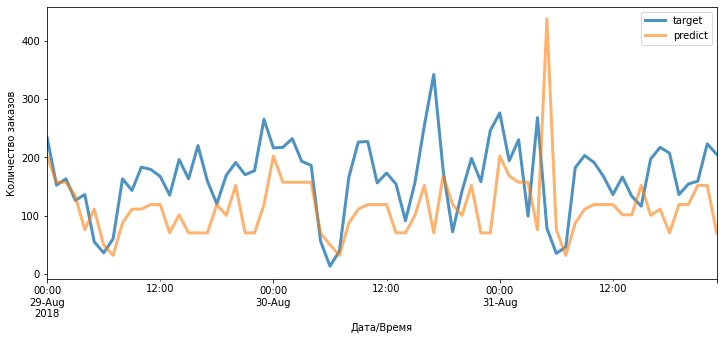

In [28]:
plot_show()

Значение RMSE на тестовой выборке лучшей DecisionTreeRegressor модели < 48, требуемый уровень не достигнут.

### RandomForestRegressor

In [37]:
df_ = df_test.copy()
make_features(df_, 12, 12)
df_ = df_.dropna()

df_t = df_train.copy()
make_features(df_t, 12, 12)
df_t = df_t.dropna()

RandomForestRegressor_best = RandomForestRegressor(random_state=12345,
                                                   max_depth=20,
                                                   n_estimators=25).fit(
    df_t.drop('num_orders', axis = 1),
    df_t['num_orders'])

print('RMSE на тестовой выборке лучшей RandomForestRegressor модели:')
predict = RandomForestRegressor_best.predict(df_.drop('num_orders', axis = 1))
mean_squared_error(df_['num_orders'],
                   predict,
                   squared=False)

RMSE на тестовой выборке лучшей RandomForestRegressor модели:


44.41496117699268

График за последние 3 дня.


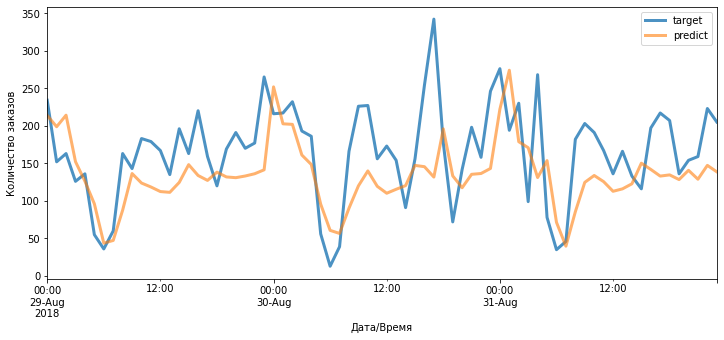

In [38]:
plot_show()

Значение RMSE на тестовой выборке лучшей RandomForestRegressor  модели < 48, требуемый уровень достигнут.

### CatBoostRegressor

In [41]:
df_ = df_test.copy()
make_features(df_, 12, 12)
df_ = df_.dropna()

df_t = df_train.copy()
make_features(df_t, 12, 12)
df_t = df_t.dropna()

CatBoostRegressor_best = CatBoostRegressor(iterations=150,
                                           learning_rate=.1,
                                           depth=8,
                                           loss_function="RMSE",
                                           verbose=False).fit(
    df_t.drop('num_orders', axis = 1),
    df_t['num_orders'])

print('RMSE на тестовой выборке лучшей CatBoostRegressor модели:')
predict = CatBoostRegressor_best.predict(df_.drop('num_orders', axis = 1))
mean_squared_error(df_['num_orders'],
                   predict,
                   squared=False)

RMSE на тестовой выборке лучшей CatBoostRegressor модели:


45.88337321821799

График за последние 3 дня.


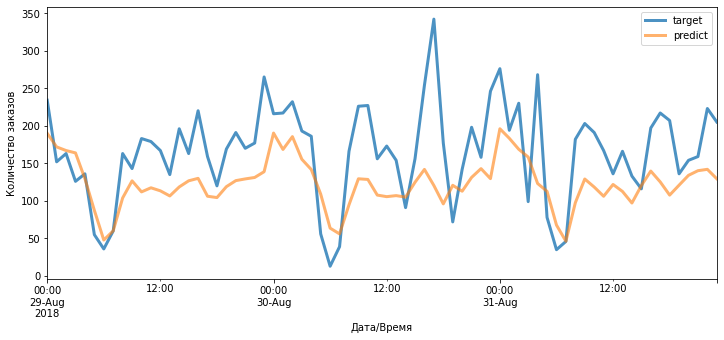

In [40]:
plot_show()

Значение RMSE на тестовой выборке лучшей CatBoostRegressor модели < 48, требуемый уровень достигнут.

### LGBMRegressor

In [42]:
df_ = df_test.copy()
make_features(df_, 12, 12)
df_ = df_.dropna()

df_t = df_train.copy()
make_features(df_t, 12, 12)
df_t = df_t.dropna()

LGBMRegressor_best = LGBMRegressor(n_estimators=150,
                                   learning_rate=.1,
                                   max_depth=6).fit(
    df_t.drop('num_orders', axis = 1),
    df_t['num_orders'])

print('RMSE на тестовой выборке лучшей LGBMRegressor модели:')
predict = LGBMRegressor_best.predict(df_.drop('num_orders', axis = 1))
mean_squared_error(df_['num_orders'],
                   predict,
                   squared=False)

RMSE на тестовой выборке лучшей LGBMRegressor модели:


44.693714200708584

График за последние 3 дня.


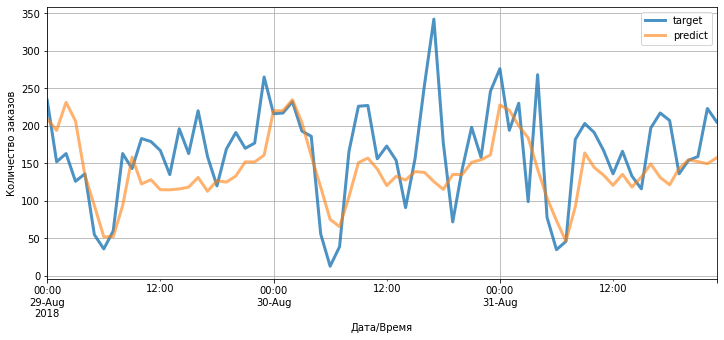

In [45]:
plot_show()

Значение RMSE на тестовой выборке лучшей LGBMRegressor модели < 48, требуемый уровень достигнут.

## Вывод

Значение RMSE на  тестовой выборке ниже 48 достигли модели:

модель | RMSE
-|-
RandomForestRegressor(random_state=12345, max_depth=20, n_estimators=150) | 44.4
CatBoostRegressor(iterations=150, learning_rate=.1, depth=8) | 45.9
LGBMRegressor(n_estimators=50, learning_rate=.1, max_depth=10) | 44.7